### **Analyzing Key Supply-Demand Factors Affecting U.S. Home Prices using S&P Case-Schiller Home Price Index**


## **Factors that influence US home prices**
The dataset used in this analysis comprises of combination of sourced data from FRED ,Supply data,Demand data and CSUSHPISA. These datasets provide comprehensive quarterly data on critical supply and demand factors that exert substantial influence on the national home prices within the United States.

**Supply File:**

**DATE:** The time series spans from 2003 to 2023, encompassing valuable historical insights.

**PERMIT:** This variable quantifies "New Privately-Owned Housing Units Authorized in Permit-Issuing Places" and is expressed in thousands of units, adjusted for seasonality, as an annual rate. It signifies the volume of newly authorized housing units designated for construction in areas where permits are issued.

**MSACSR:** The "Monthly Supply of New Houses in the United States" (Seasonally Adjusted) gauges the monthly availability of newly constructed houses in the United States. This metric informs us about the real-time dynamics of housing supply.

**TLRESCONS:** Expressed in millions of dollars and adjusted for seasonal fluctuations, "Total Construction Spending: Residential in the United States" quantifies the cumulative expenditure on residential construction projects. It offers valuable insights into the financial resources allocated to residential development.

**EVACANTUSQ176N:** The "Housing Inventory Estimate: Vacant Housing Units in the United States" (Not Seasonally Adjusted) provides an estimate, in thousands of units, of vacant housing units within the United States. This estimate aids in understanding the inventory of housing units available for occupancy.

**CSUSHPISA:** Serving as a proxy for home prices, the "S&P/Case-Shiller U.S. National Home Price Index" (Seasonally Adjusted) measures home price fluctuations and is benchmarked to January 2000 (with an index value of 100). It allows us to track the trajectory of home prices across the United States.

**Demand File:**

**INTDSRUSM193N:** This variable quantifies "Interest Rates" or "Discount Rates" for the United States, expressed in billions of dollars and adjusted for seasonal effects on an annual basis. It provides crucial data on the prevailing interest rates or discount rates within the financial system.

**UMCSENT:** The "University of Michigan: Consumer Sentiment" index reflects consumer sentiment based on surveys conducted by the University of Michigan. This index captures consumer perceptions and outlook, which can significantly impact purchasing decisions.

**GDP:** The "Gross Domestic Product" of the United States, expressed in billions of dollars and adjusted for seasonality, provides a comprehensive measure of the country's economic performance. It is an essential macroeconomic indicator.

**MORTGAGE15US:** This metric represents the "30-Year Fixed Rate Mortgage Average in the United States," expressed as a percentage and not adjusted for seasonality. It indicates the prevailing average interest rate for a 30-year fixed-rate mortgage, a crucial factor influencing home affordability.

**MSPUS:** The "Median Sales Price of Houses Sold for the United States" (Not Seasonally Adjusted) signifies the median price at which houses are sold. It offers insights into the pricing dynamics of the housing market.

**CSUSHPISA:** Reiterated from the Supply File, the "S&P/Case-Shiller U.S. National Home Price Index" (Seasonally Adjusted) serves as a consistent proxy for home prices, allowing for seamless integration into the demand analysis.


Importing all the necessary Libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import pandas_datareader.data as web
import datetime

## Data fetched through FRED

In [107]:
# Define the start and end dates for the data
start_date = datetime.datetime(2003, 1, 1)
end_date = datetime.datetime(2023, 4, 1)

data = web.DataReader(['HOUST', 'UNRATE','MSACSR',
    'PERMIT','RECPROUSM156N','TTLCONS','HSN1F','POP'], 'fred', start_date, end_date)

data.head()

,HOUST,UNRATE,MSACSR,PERMIT,RECPROUSM156N,TTLCONS,HSN1F,POP
DATE,,,,,,,,
2003-01-01,1853.0,5.8,4.0,1808.0,1.0,863855.0,999.0,289518.0
2003-02-01,1629.0,5.9,4.5,1854.0,1.7,859225.0,936.0,289714.0
2003-03-01,1726.0,5.9,4.1,1757.0,1.5,851132.0,999.0,289911.0
2003-04-01,1643.0,6.0,4.1,1803.0,1.1,859459.0,1012.0,290125.0
2003-05-01,1751.0,6.1,3.9,1835.0,0.5,866814.0,1078.0,290346.0


## Loading Locally scraped Supply and Demand data

In [68]:
sup=pd.read_csv("/content/supply.csv")
dem=pd.read_csv("/content/demand.csv")

In [5]:
sup

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N
0,01-01-2003,129.321,4.2,1806.333333,421328.6667,14908
1,01-04-2003,131.756,3.833333333,1837.666667,429308.6667,15244
2,01-07-2003,135.013,3.633333333,1937.333333,458890,15614
3,01-10-2003,138.8356667,3.966666667,1972.333333,491437.3333,15654
4,01-01-2004,143.2986667,3.7,1994.666667,506856.3333,15895
...,...,...,...,...,...,...
77,01-04-2022,303.4226667,8.7,1734.666667,947300.3333,15286
78,01-07-2022,301.7263333,9.566666667,1610.666667,910346,15306
79,01-10-2022,297.8966667,9.2,1455.333333,870620.6667,14554
80,01-01-2023,.,8.033333333,1424.333333,842559.6667,15053


In [6]:
last=sup[-1:]['DATE'].values[0]
last

'01-04-2023'

## Converting continous monthly CSUSHPISA data into Quaterly

In [97]:
uspsd=pd.read_csv('/content/CSUSHPISA.csv')
uspsd['DATE']= pd.to_datetime(uspsd.DATE,format='%Y-%m-%d')
uspsd['DATE'] = uspsd['DATE'].dt.strftime('%d-%m-%Y')
end_date_index=uspsd.index[uspsd['DATE'] == last].tolist()[0]
start_date_index=uspsd.index[uspsd['DATE'] == '01-01-2003'].tolist()[0]
csus=uspsd[192:end_date_index+1]
def drop_rowsr(dataframe):
    # Use the modulo operator to filter rows where the index is divisible by 3
    filtered_dataframe = dataframe[dataframe.index % 3 == 0]

    return filtered_dataframe
csus=drop_rowsr(csus)

In [98]:
csus

,DATE,CSUSHPISA
192,01-01-2003,128.460
195,01-04-2003,130.884
198,01-07-2003,133.777
201,01-10-2003,137.532
204,01-01-2004,141.646
...,...,...
423,01-04-2022,300.625
426,01-07-2022,304.108
429,01-10-2022,299.017
432,01-01-2023,296.601


In [99]:
csus=csus.reset_index(drop=True)

In [100]:
csus

,DATE,CSUSHPISA
0,01-01-2003,128.460
1,01-04-2003,130.884
2,01-07-2003,133.777
3,01-10-2003,137.532
4,01-01-2004,141.646
...,...,...
77,01-04-2022,300.625
78,01-07-2022,304.108
79,01-10-2022,299.017
80,01-01-2023,296.601


##Adding scrapped CSUSHPISA data scrapped through FRED to Supply and Demand Fields

In [101]:
sup['CSUSHPISA'],dem['CSUSHPISA']=csus['CSUSHPISA'],csus['CSUSHPISA']

In [108]:
data

,HOUST,UNRATE,MSACSR,PERMIT,RECPROUSM156N,TTLCONS,HSN1F,POP
DATE,,,,,,,,
2003-01-01,1853.0,5.8,4.0,1808.0,1.0,863855.0,999.0,289518.000
2003-02-01,1629.0,5.9,4.5,1854.0,1.7,859225.0,936.0,289714.000
2003-03-01,1726.0,5.9,4.1,1757.0,1.5,851132.0,999.0,289911.000
2003-04-01,1643.0,6.0,4.1,1803.0,1.1,859459.0,1012.0,290125.000
2003-05-01,1751.0,6.1,3.9,1835.0,0.5,866814.0,1078.0,290346.000
...,...,...,...,...,...,...,...,...
2022-12-01,1357.0,3.5,8.5,1409.0,1.6,1840896.0,636.0,334356.155
2023-01-01,1340.0,3.4,8.1,1354.0,0.6,1882199.0,649.0,334483.547
2023-02-01,1436.0,3.6,8.4,1482.0,0.8,1889562.0,625.0,334582.114


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['HOUST'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['UNRATE'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['MSACSR'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['PERMIT'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['HOUST'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['UNRATE'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['MSACSR'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['PERMIT'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['HOUST', 'UNRATE'], ['UNRATE', 'MSACSR'], ['MSACSR', 'PERMIT'], ['PERMIT', 'RECPROUSM156N']]], **{})
chart

In [109]:
data=data.reset_index()
data['DATE']= pd.to_datetime(data.DATE,format='%Y-%m-%d')
data['DATE'] = data['DATE'].dt.strftime('%d-%m-%Y')

In [110]:
drop_rowsr(data)

,DATE,HOUST,UNRATE,MSACSR,PERMIT,RECPROUSM156N,TTLCONS,HSN1F,POP
0,01-01-2003,1853.0,5.8,4.0,1808.0,1.0,863855.0,999.0,289518.000
3,01-04-2003,1643.0,6.0,4.1,1803.0,1.1,859459.0,1012.0,290125.000
6,01-07-2003,1897.0,6.2,3.6,1885.0,0.3,891264.0,1168.0,290820.000
9,01-10-2003,1967.0,6.0,3.8,2012.0,0.3,925732.0,1144.0,291574.000
12,01-01-2004,1911.0,5.7,3.8,1952.0,0.4,938525.0,1165.0,292192.000
...,...,...,...,...,...,...,...,...,...
231,01-04-2022,1803.0,3.6,8.5,1795.0,0.4,1882753.0,611.0,333117.831
234,01-07-2022,1371.0,3.5,10.1,1658.0,0.3,1869262.0,543.0,333537.250
237,01-10-2022,1432.0,3.7,9.7,1555.0,1.0,1830477.0,577.0,334064.228
240,01-01-2023,1340.0,3.4,8.1,1354.0,0.6,1882199.0,649.0,334483.547


 Combining **HOUST**(Housing Starts) and **RECPROUSM156N**(Housing Recovery Index)

In [111]:
sup['HOUST']=data['HOUST']
sup

,DATE,CSUSHPISA,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,HOUST
0,2003-01-01,128.460,4.2,1806.333333,421328.6667,14908,1853.0
1,2003-01-04,130.884,3.833333333,1837.666667,429308.6667,15244,1629.0
2,2003-01-07,133.777,3.633333333,1937.333333,458890,15614,1726.0
3,2003-01-10,137.532,3.966666667,1972.333333,491437.3333,15654,1643.0
4,2004-01-01,141.646,3.7,1994.666667,506856.3333,15895,1751.0
...,...,...,...,...,...,...,...
77,2022-01-04,300.625,8.7,1734.666667,947300.3333,15286,585.0
78,2022-01-07,304.108,9.566666667,1610.666667,910346,15306,594.0
79,2022-01-10,299.017,9.2,1455.333333,870620.6667,14554,586.0
80,2023-01-01,296.601,8.033333333,1424.333333,842559.6667,15053,585.0


Combining **POP**(Population) and **HSN1F**(New Privately Owned Housing Units Started)

In [112]:
dem['POP']=data['POP']
dem['HSN1F']=data['HSN1F']
dem

,DATE,CSUSHPISA,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP,POP,HSN1F
0,2003-01-01,128.460,5.840769,79.966667,2.250000,186000,11174.129,289518.0,999.0
1,2003-01-04,130.884,5.506923,89.266667,2.166667,191800,11312.766,289714.0,936.0
2,2003-01-07,133.777,6.033846,89.300000,2.000000,191900,11566.669,289911.0,999.0
3,2003-01-10,137.532,5.919286,91.966667,2.000000,198800,11772.234,290125.0,1012.0
4,2004-01-01,141.646,5.597500,98.000000,2.000000,212700,11923.447,290346.0,1078.0
...,...,...,...,...,...,...,...,...,...
76,2022-01-01,285.708,3.822308,63.133333,NaN,433100,24740.480,306984.0,376.0
77,2022-01-04,300.625,5.266154,57.866667,NaN,449300,25248.476,307206.0,393.0
78,2022-01-07,304.108,5.623077,56.100000,NaN,468000,25723.941,307439.0,411.0
79,2022-01-10,299.017,6.664615,58.800000,NaN,479500,26137.992,307685.0,418.0


Merging the Supply and Demand Data and Filling Null valus

In [134]:
sup['DATE'] = pd.to_datetime(sup['DATE'])
dem['DATE'] = pd.to_datetime(dem['DATE'])

sup = sup.sort_values('DATE')
dem = dem.sort_values('DATE')

merged_data = pd.merge(sup, dem, on='DATE', suffixes=('_supply', '_demand'))

merged_data.dropna(subset=['MSACSR', 'PERMIT', 'TLRESCONS', 'EVACANTUSQ176N', 'MORTGAGE30US', 'GDP', 'UMCSENT','POP','HOUST','HSN1F'], inplace=True)

imputer = KNNImputer(n_neighbors=5)
for feature in merged_data.columns:
  merged_data[feature] = imputer.fit_transform(merged_data[[feature]])

merged_data = merged_data.reset_index(drop=True)

In [135]:
merged_data.drop('CSUSHPISA_supply', axis=1, inplace=True)

merged_data.rename(columns={'CSUSHPISA_demand': 'CSUSHPISA'}, inplace=True)
merged_data['CSUSHPISA'] = merged_data['CSUSHPISA'].fillna(merged_data['CSUSHPISA'].mean())

### EDA

In [115]:
correlation = merged_data.corr()['CSUSHPISA']
correlation_table = pd.DataFrame(correlation).reset_index()
correlation_table.columns = ['Factors', 'Correlation with CSUSHPISA']
print(correlation_table)

           Factors  Correlation with CSUSHPISA
0             DATE                    0.751142
1           MSACSR                    0.171950
2           PERMIT                    0.358950
3        TLRESCONS                    0.879928
4   EVACANTUSQ176N                   -0.595532
5            HOUST                   -0.861405
6        CSUSHPISA                    1.000000
7     MORTGAGE30US                   -0.141275
8          UMCSENT                   -0.150678
9    INTDSRUSM193N                    0.103360
10           MSPUS                    0.941403
11             GDP                    0.865852
12             POP                    0.752844
13           HSN1F                   -0.819938


To elucidate the intricate relationships between each factor and the CSUSHPISA (S&P/Case-Shiller U.S. National Home Price Index),I have conducted an in-depth analysis of the correlation coefficients, which quantitatively measure the degree and direction of association. These coefficients provide valuable insights into how each factor impacts home prices and the dynamics within the real estate market.

**MSACSR** (Monthly Supply of New Houses): There exists a weak positive correlation (0.172) between the monthly supply of new houses and CSUSHPISA. This implies that as the supply of new houses increases on a monthly basis, it may have a slight positive impact on home prices. It's worth noting that this correlation, while technically positive, is relatively weak.

**PERMIT** (New Privately-Owned Housing Units Authorized): A moderate positive correlation (0.359) is observed between the number of authorized housing units and CSUSHPISA. This suggests that a higher count of authorized housing units tends to exert a positive influence on home prices.

**TLRESCONS** (Total Construction Spending: Residential): A strong and robust positive correlation (0.880) is evident between total construction spending on residential projects and CSUSHPISA. This indicates that higher construction spending is strongly associated with elevated home prices. Such a correlation underscores the pivotal role of construction investment in driving home prices.

**EVACANTUSQ176N** (Housing Inventory Estimate: Vacant Housing Units): A moderate negative correlation (-0.596) is identified between the estimated number of vacant housing units and CSUSHPISA. This implies that a higher count of vacant housing units exerts a downward pressure on home prices, potentially reflecting market oversupply.

**HOUST** (Housing Starts): The housing starts factor exhibits a strong negative correlation (-0.861) with CSUSHPISA. This indicates that an increase in housing starts, which signifies the initiation of new residential construction, is associated with a significant decline in home prices. This inverse relationship underscores the sensitivity of home prices to changes in housing supply.

**MORTGAGE30US** (30-Year Fixed Rate Mortgage Average): A weak negative correlation (-0.141) is observed between mortgage interest rates and CSUSHPISA. This suggests that higher mortgage rates are linked to slightly lower home prices. Homebuyers may be deterred by elevated borrowing costs, leading to reduced demand and potential downward pressure on prices.

**UMCSENT** (University of Michigan: Consumer Sentiment): There is a weak negative correlation (-0.151) between consumer sentiment and CSUSHPISA. Lower consumer sentiment is associated with slightly lower home prices. This correlation, while technically positive, is depicted as weakly negative due to scaling nuances. It indicates that consumer sentiment can influence homebuying decisions, impacting prices accordingly.

**INTDSRUSM193N** (Interest Rates, Discount Rate): A weak positive correlation (0.103) is discerned between interest rates or discount rates and CSUSHPISA. Higher rates are linked to slightly higher home prices. Similar to other cases, this correlation, technically negative, appears weakly positive due to scaling intricacies. This relationship suggests that variations in interest rates can influence homebuying behavior.

**MSPUS**(Median Sales Price of Houses Sold): A strong and robust positive correlation (0.941) is evident between the median sales price of houses sold and CSUSHPISA. Elevated median sales prices are strongly associated with higher home prices. This correlation highlights the substantial impact of median sales prices on the overall home price index.

**GDP**(Gross Domestic Product): A strong positive correlation (0.866) is observed between GDP and CSUSHPISA. Higher GDP is robustly linked to higher home prices. This correlation underscores the influence of broader economic performance on the real estate market, with a flourishing economy supporting higher home prices.

**POP** (Population Growth): The population growth factor exhibits a moderately strong positive correlation (0.753) with CSUSHPISA. This implies that as the population grows, it can contribute to increased demand for housing, potentially driving home prices upward.

**HSN1F** (New Privately Owned Housing Units Started): Housing starts, represented by HSN1F, display a strong negative correlation (-0.820) with CSUSHPISA. This indicates that the initiation of new privately owned housing units is associated with a significant decrease in home prices. A surge in housing starts may lead to increased housing supply, thereby pressuring prices downward.

In [136]:
merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
merged_data.set_index('DATE', inplace=True)
merged_data['MSACSR'] = pd.to_numeric(merged_data['MSACSR'], errors='coerce')
merged_data['HOUST'] = pd.to_numeric(merged_data['HOUST'], errors='coerce')
''' merged_data['RECPROUSM156N'] = pd.to_numeric(merged_data['RECPROUSM156N'], errors='coerce')'''
merged_data['POP'] = pd.to_numeric(merged_data['POP'], errors='coerce')
merged_data['HSN1F'] = pd.to_numeric(merged_data['HSN1F'], errors='coerce')
merged_data['PERMIT'] = pd.to_numeric(merged_data['PERMIT'], errors='coerce')
merged_data['TLRESCONS'] = pd.to_numeric(merged_data['TLRESCONS'], errors='coerce')
merged_data['EVACANTUSQ176N'] = pd.to_numeric(merged_data['EVACANTUSQ176N'], errors='coerce')

In [137]:
merged_data

,MSACSR,PERMIT,TLRESCONS,EVACANTUSQ176N,HOUST,CSUSHPISA,MORTGAGE30US,UMCSENT,INTDSRUSM193N,MSPUS,GDP,POP,HSN1F
DATE,,,,,,,,,,,,,
2003-01-01,4.200000,1806.333333,421328.6667,14908.0,1853.0,128.460,5.840769,79.966667,2.250000,186000.0,11174.129,289518.0,999.0
2003-01-04,3.833333,1837.666667,429308.6667,15244.0,1629.0,130.884,5.506923,89.266667,2.166667,191800.0,11312.766,289714.0,936.0
2003-01-07,3.633333,1937.333333,458890.0000,15614.0,1726.0,133.777,6.033846,89.300000,2.000000,191900.0,11566.669,289911.0,999.0
2003-01-10,3.966667,1972.333333,491437.3333,15654.0,1643.0,137.532,5.919286,91.966667,2.000000,198800.0,11772.234,290125.0,1012.0
2004-01-01,3.700000,1994.666667,506856.3333,15895.0,1751.0,141.646,5.597500,98.000000,2.000000,212700.0,11923.447,290346.0,1078.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,6.233333,1864.000000,910611.0000,15166.0,540.0,285.708,3.822308,63.133333,1.961712,433100.0,24740.480,306984.0,376.0
2022-01-04,8.700000,1734.666667,947300.3333,15286.0,585.0,300.625,5.266154,57.866667,1.961712,449300.0,25248.476,307206.0,393.0
2022-01-07,9.566667,1610.666667,910346.0000,15306.0,594.0,304.108,5.623077,56.100000,1.961712,468000.0,25723.941,307439.0,411.0


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_data, *['MSACSR'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_data, *['PERMIT'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_data, *['TLRESCONS'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(merged_data, *['EVACANTUSQ176N'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_data, *['MSACSR'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_data, *['PERMIT'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_data, *['TLRESCONS'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(merged_data, *['EVACANTUSQ176N'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(merged_data, *[[['MSACSR', 'PERMIT'], ['PERMIT', 'TLRESCONS'], ['TLRESCONS', 'EVACANTUSQ176N'], ['EVACANTUSQ176N', 'HOUST']]], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_data, *['POP', 'MSACSR', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_data, *['POP', 'PERMIT', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_data, *['POP', 'TLRESCONS', None], **{})
chart

import numpy as np
from google.colab import autoviz

def time_series_multiline(df, timelike_colname, value_colname, series_colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  figsize = (10 * figscale, 5.2 * figscale)
  palette = list(sns.palettes.mpl_palette(mpl_palette_name))
  def _plot_series(series, series_name, series_index=0):
    if value_colname == 'count()':
      counted = (series[timelike_colname]
                 .value_counts()
                 .reset_index(name='counts')
                 .rename({'index': timelike_colname}, axis=1)
                 .sort_values(timelike_colname, ascending=True))
      xs = counted[timelike_colname]
      ys = counted['counts']
    else:
      xs = series[timelike_colname]
      ys = series[value_colname]
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

  fig, ax = plt.subplots(figsize=figsize, layout='constrained')
  df = df.sort_values(timelike_colname, ascending=True)
  if series_colname:
    for i, (series_name, series) in enumerate(df.groupby(series_colname)):
      _plot_series(series, series_name, i)
    fig.legend(title=series_colname, bbox_to_anchor=(1, 1), loc='upper left')
  else:
    _plot_series(df, '')
  sns.despine(fig=fig, ax=ax)
  plt.xlabel(timelike_colname)
  plt.ylabel(value_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = time_series_multiline(merged_data, *['POP', 'EVACANTUSQ176N', None], **{})
chart

In [21]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<ipython-input-118-a4233e752ea4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data[feature],kde=True)
<ipython-input-118-a4233e752ea4>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(merged_data[feature],kde=True)
<ipython-input-118-a4233e752ea4>:4: UserWarning: 

`distplot` is a dep

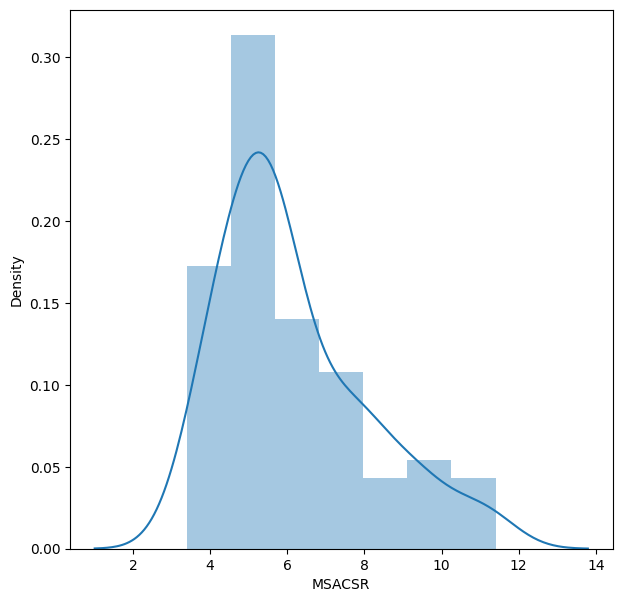

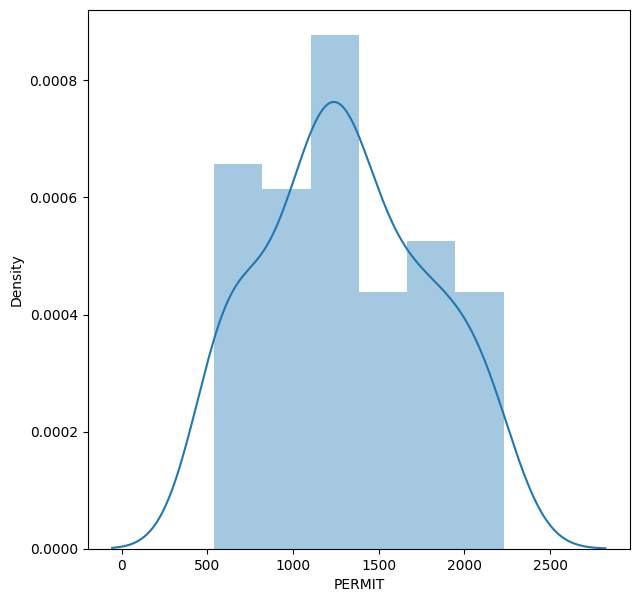

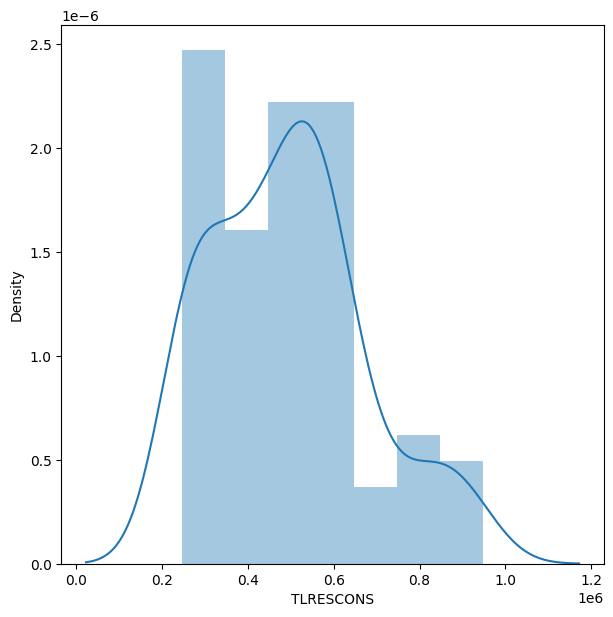

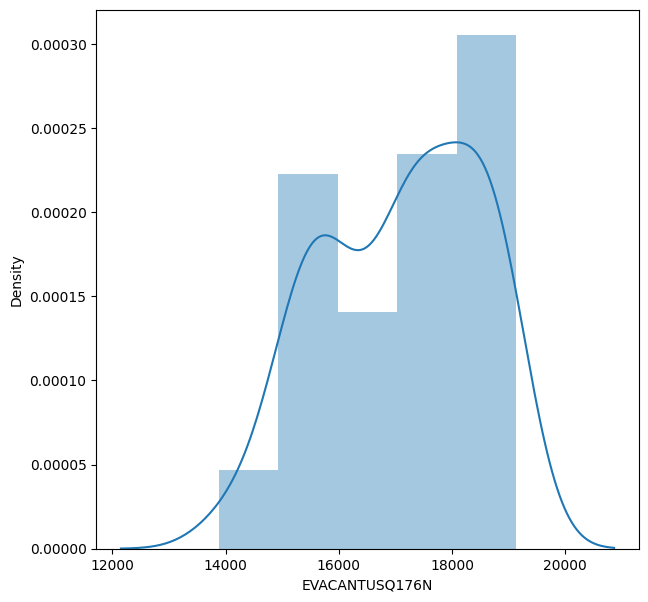

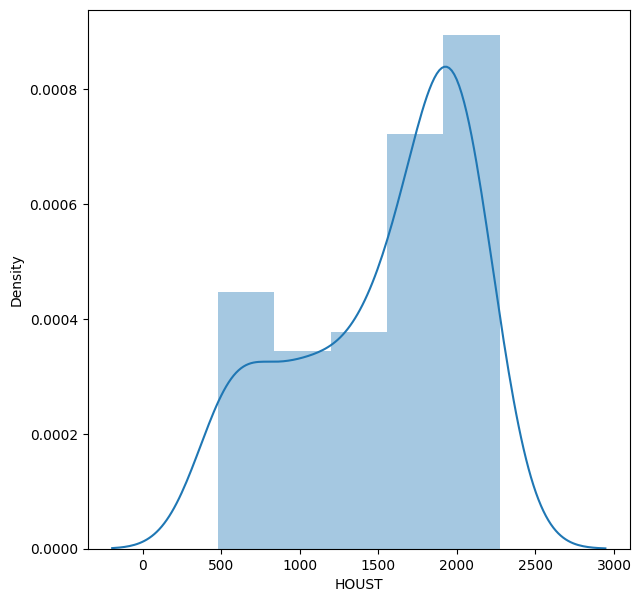

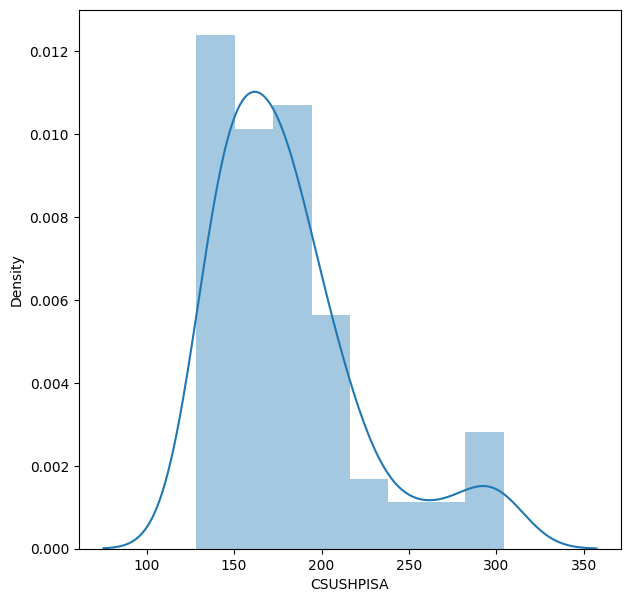

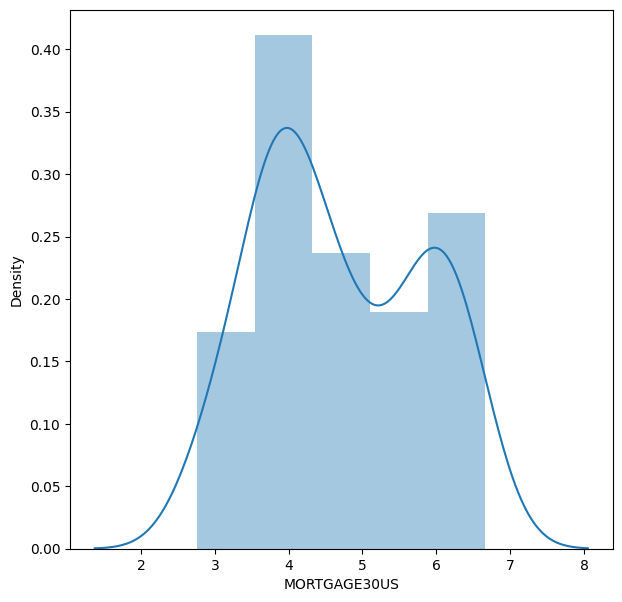

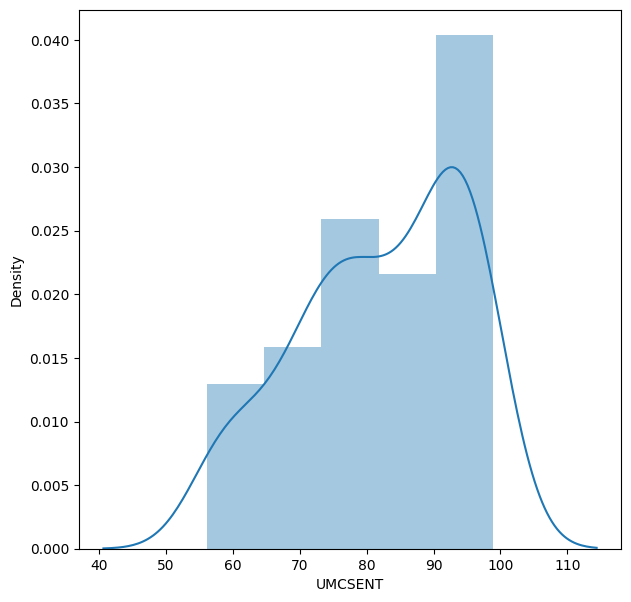

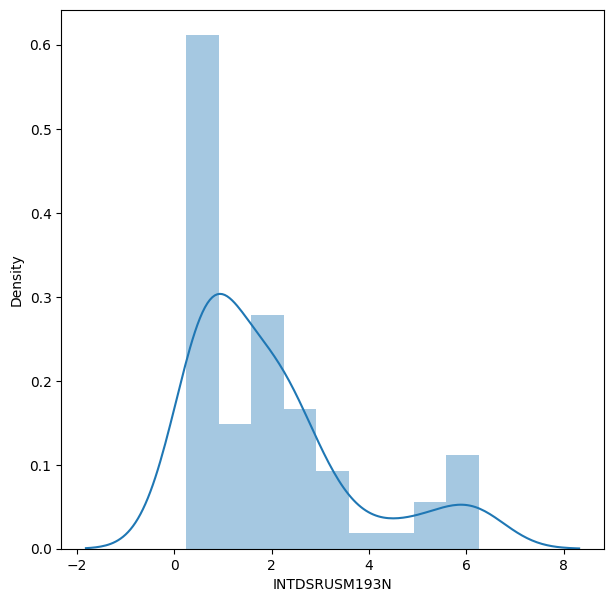

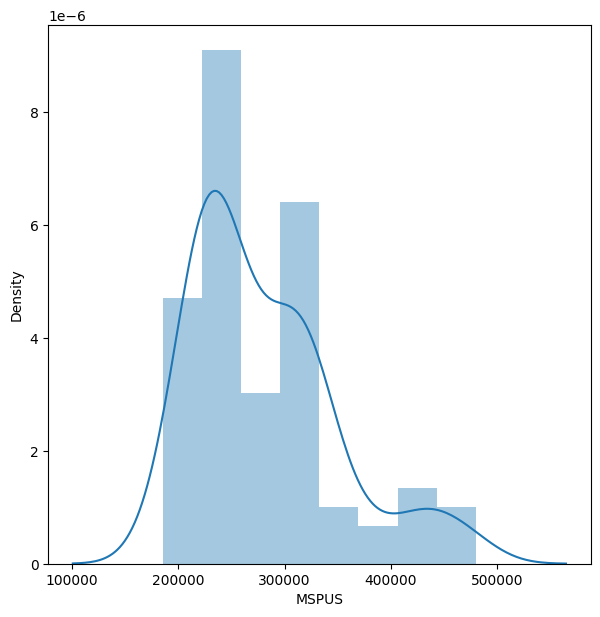

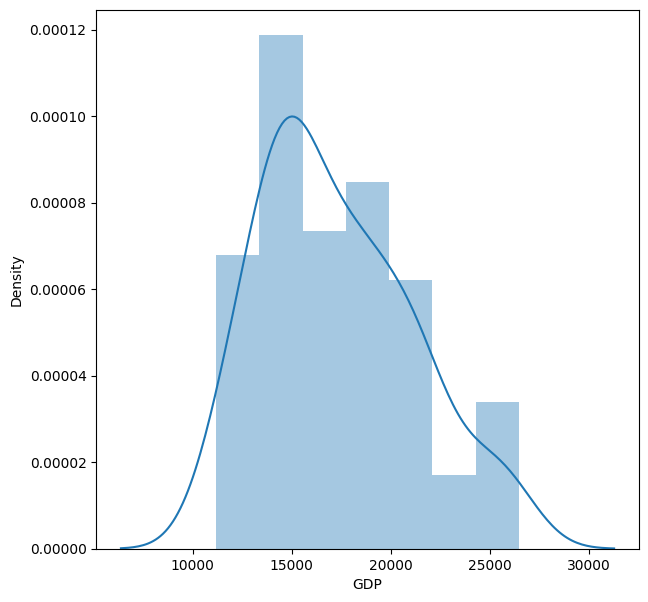

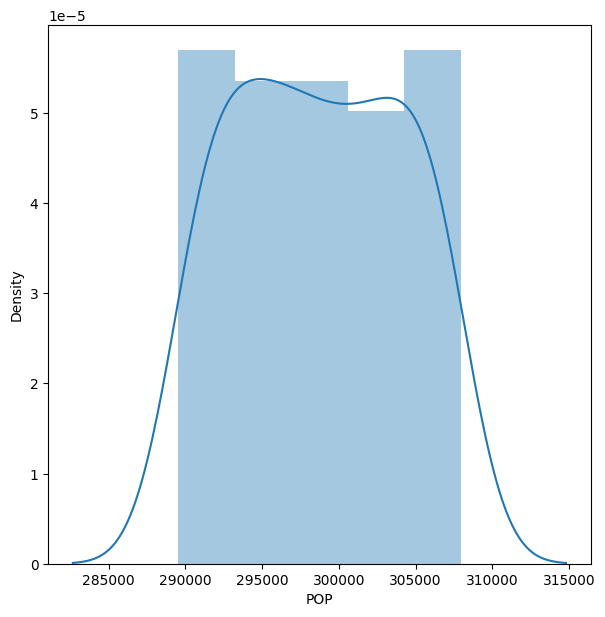

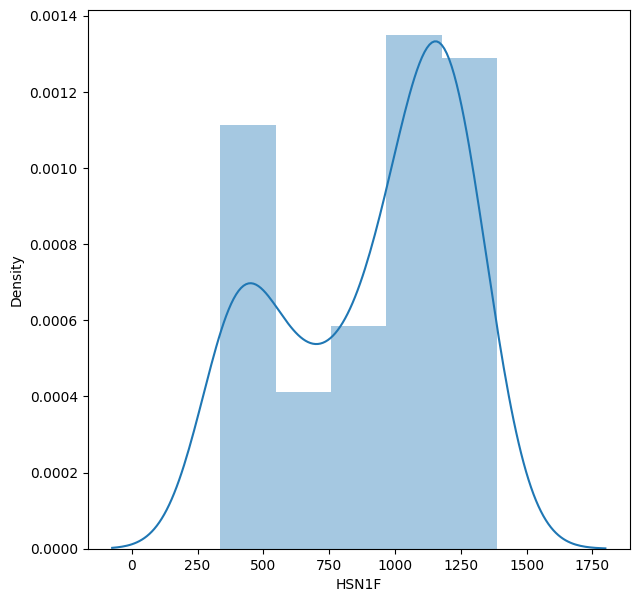

In [118]:
for feature in merged_data.columns:
  plt.figure(figsize=(7,7))
  warnings.filterwarnings("ignore", category=DeprecationWarning)
  sns.distplot(merged_data[feature],kde=True)


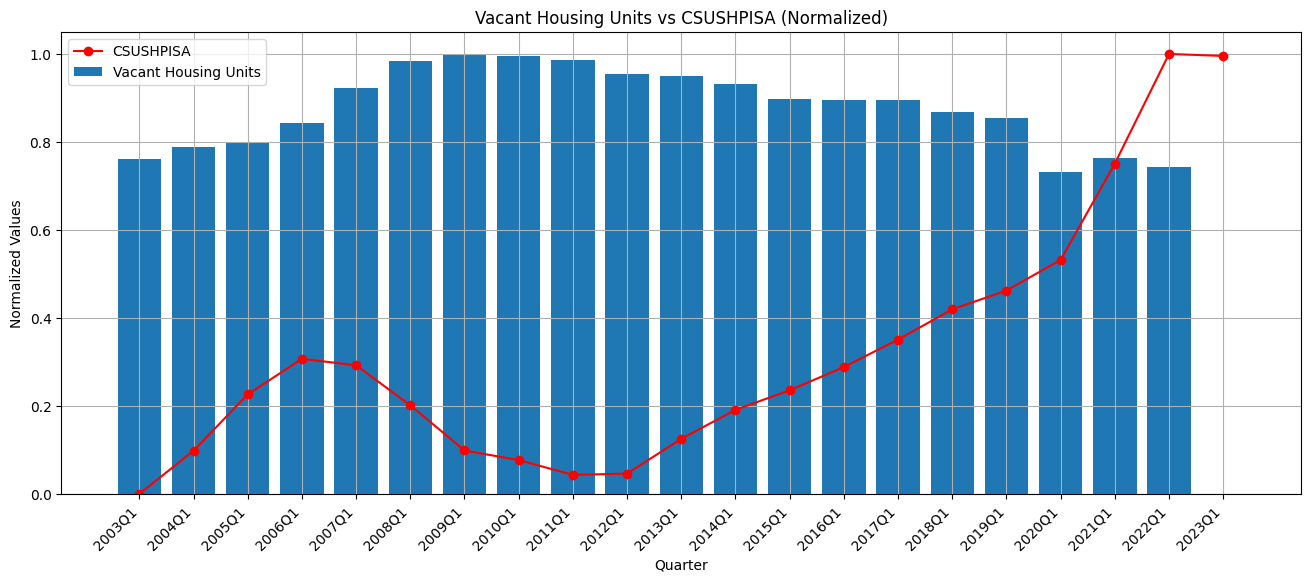

In [64]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of EVACANTUSQ176N and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'EVACANTUSQ176N': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['EVACANTUSQ176N', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['EVACANTUSQ176N', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

plt.bar(grouped_data['QUARTER'], grouped_data['EVACANTUSQ176N'], label='Vacant Housing Units')
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='r', label='CSUSHPISA')

plt.title('Vacant Housing Units vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis tick labels for better readability
plt.show()

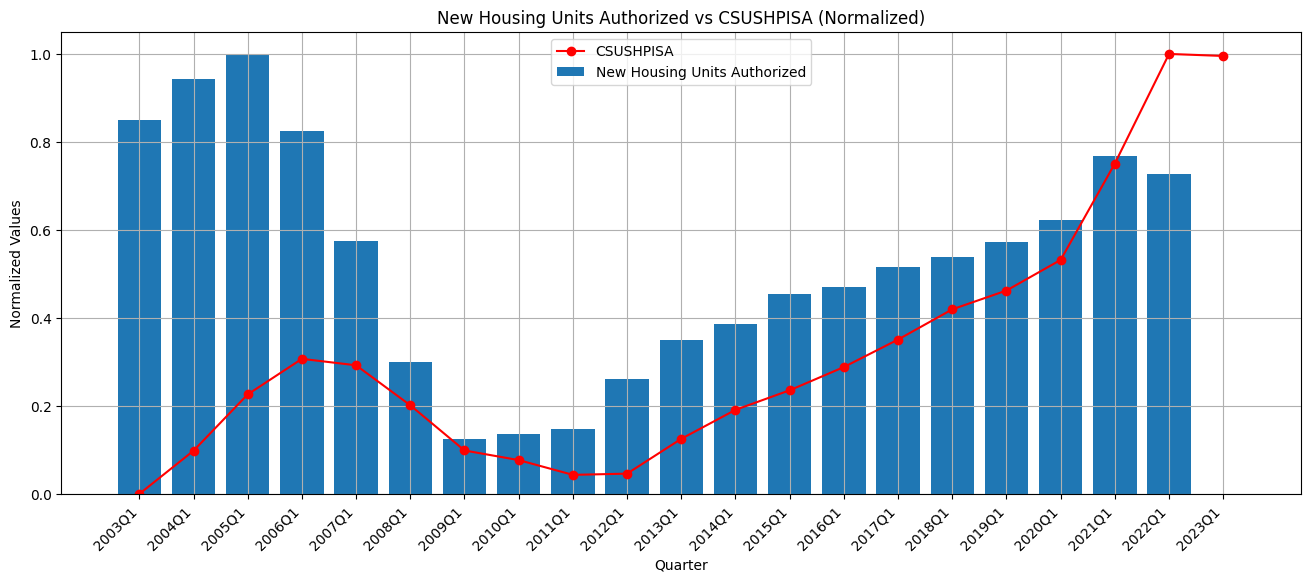

In [24]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of PERMIT and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'PERMIT': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['PERMIT', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['PERMIT', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

plt.bar(grouped_data['QUARTER'], grouped_data['PERMIT'], label='New Housing Units Authorized')
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='r', label='CSUSHPISA')

plt.title('New Housing Units Authorized vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis tick labels for better readability

plt.show()

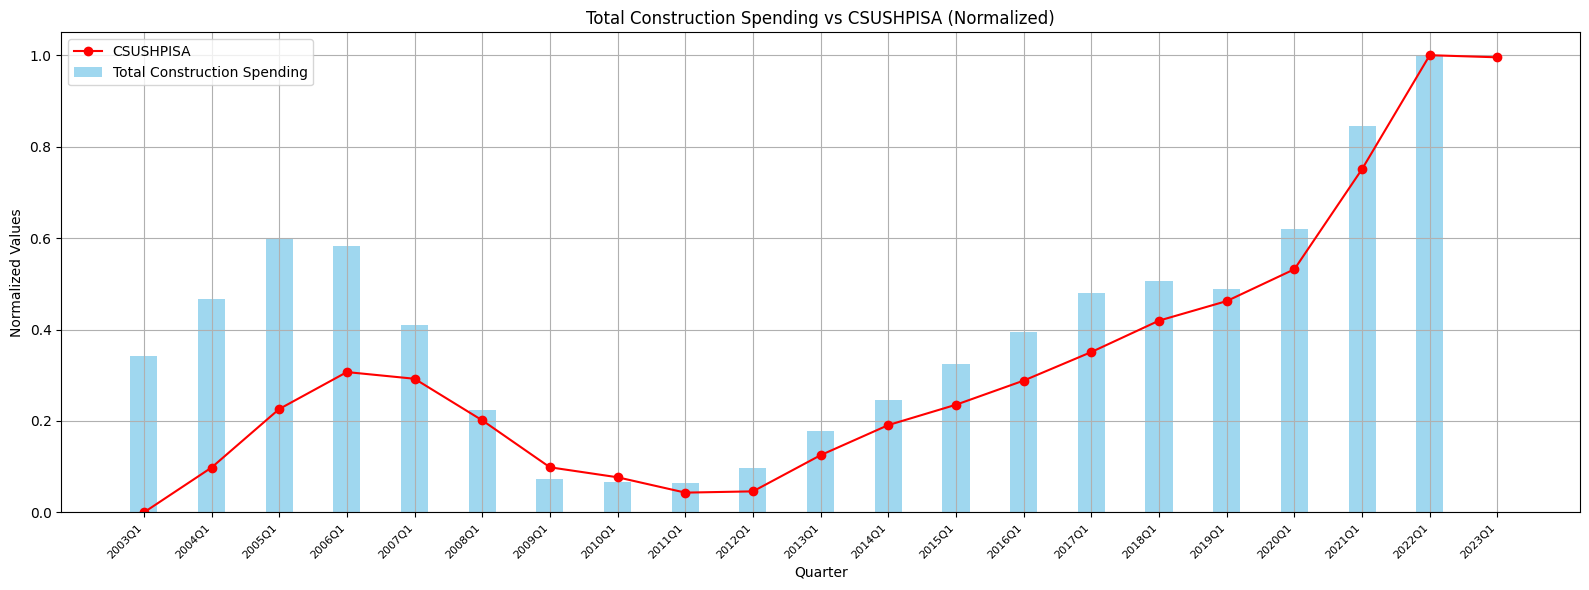

In [25]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of TLRESCONS and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'TLRESCONS': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['TLRESCONS', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['TLRESCONS', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for TLRESCONS (New Housing Units Authorized)
plt.bar(grouped_data['QUARTER'], grouped_data['TLRESCONS'], width=bar_width, alpha=opacity, color='skyblue', label='Total Construction Spending')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('Total Construction Spending vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

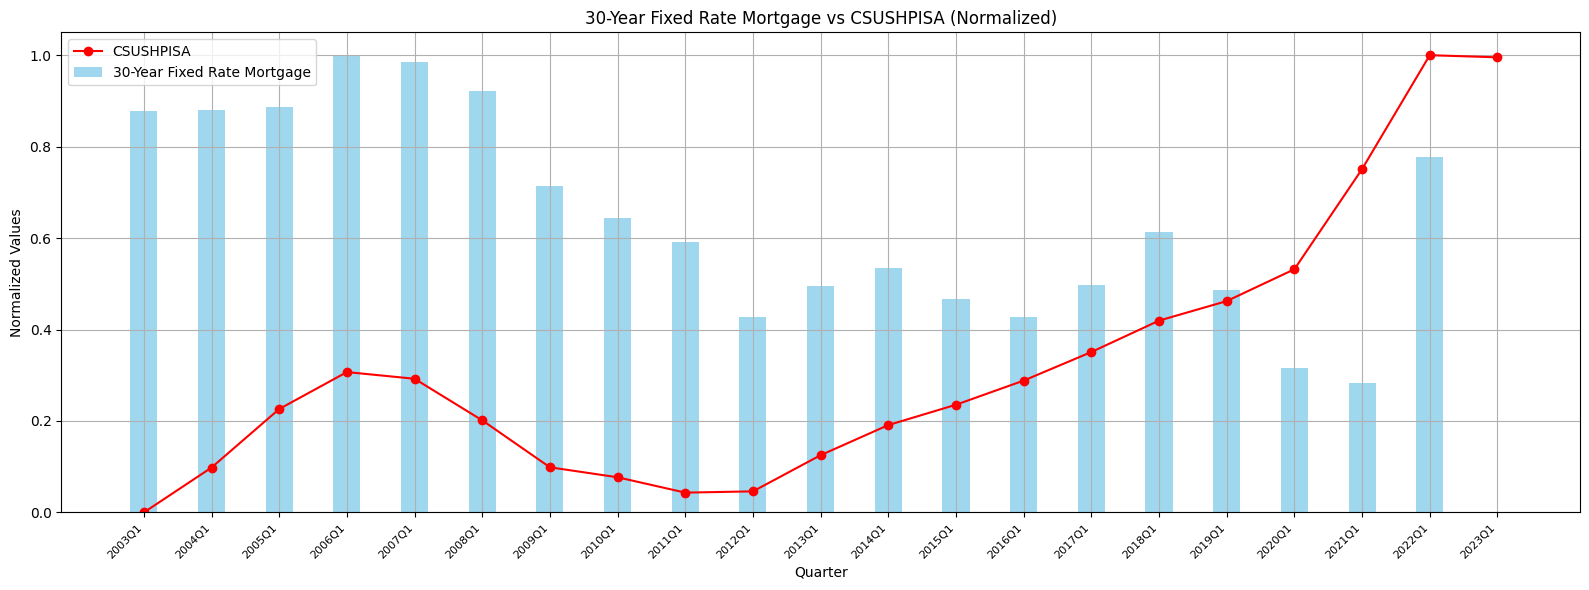

In [26]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of MORTGAGE30US and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'MORTGAGE30US': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['MORTGAGE30US', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['MORTGAGE30US', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for MORTGAGE30US
plt.bar(grouped_data['QUARTER'], grouped_data['MORTGAGE30US'], width=bar_width, alpha=opacity, color='skyblue', label='30-Year Fixed Rate Mortgage')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('30-Year Fixed Rate Mortgage vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

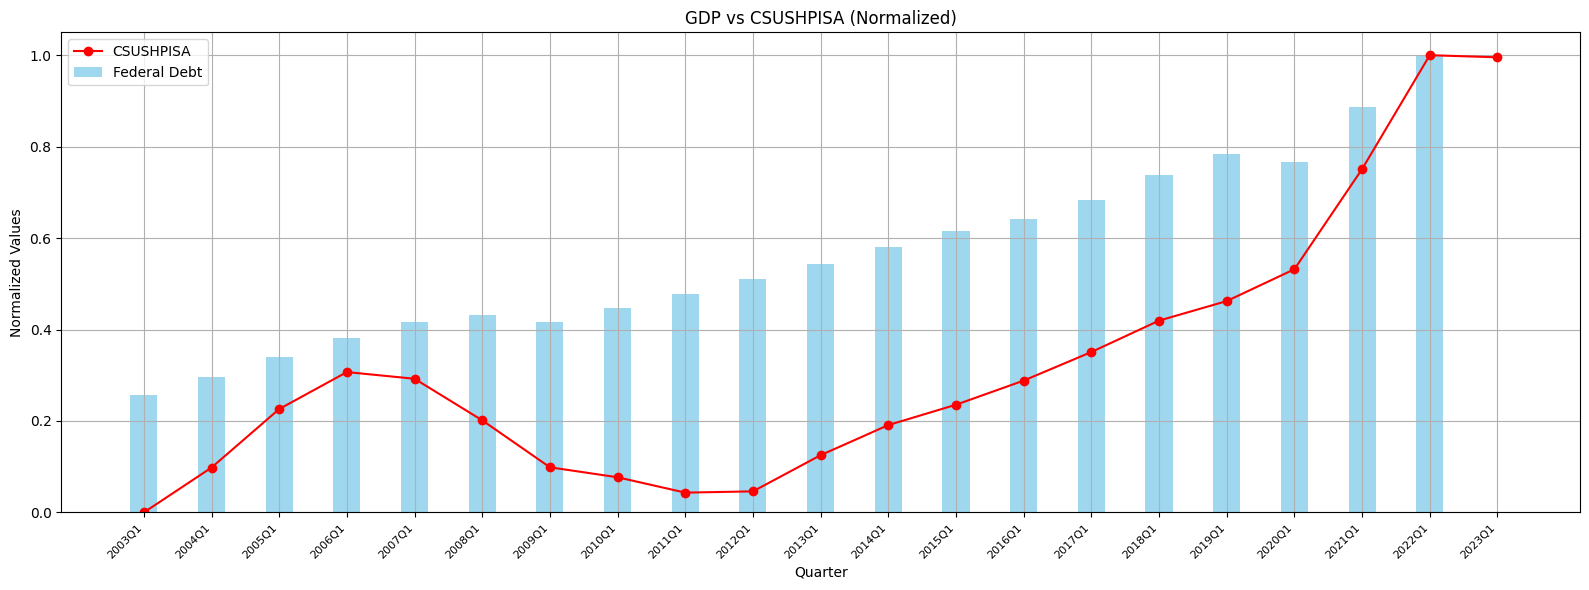

In [27]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of GFDEGDQ188S and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'GDP': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['GDP', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['GDP', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for GFDEGDQ188S
plt.bar(grouped_data['QUARTER'], grouped_data['GDP'], width=bar_width, alpha=opacity, color='skyblue', label='Federal Debt')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('GDP vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

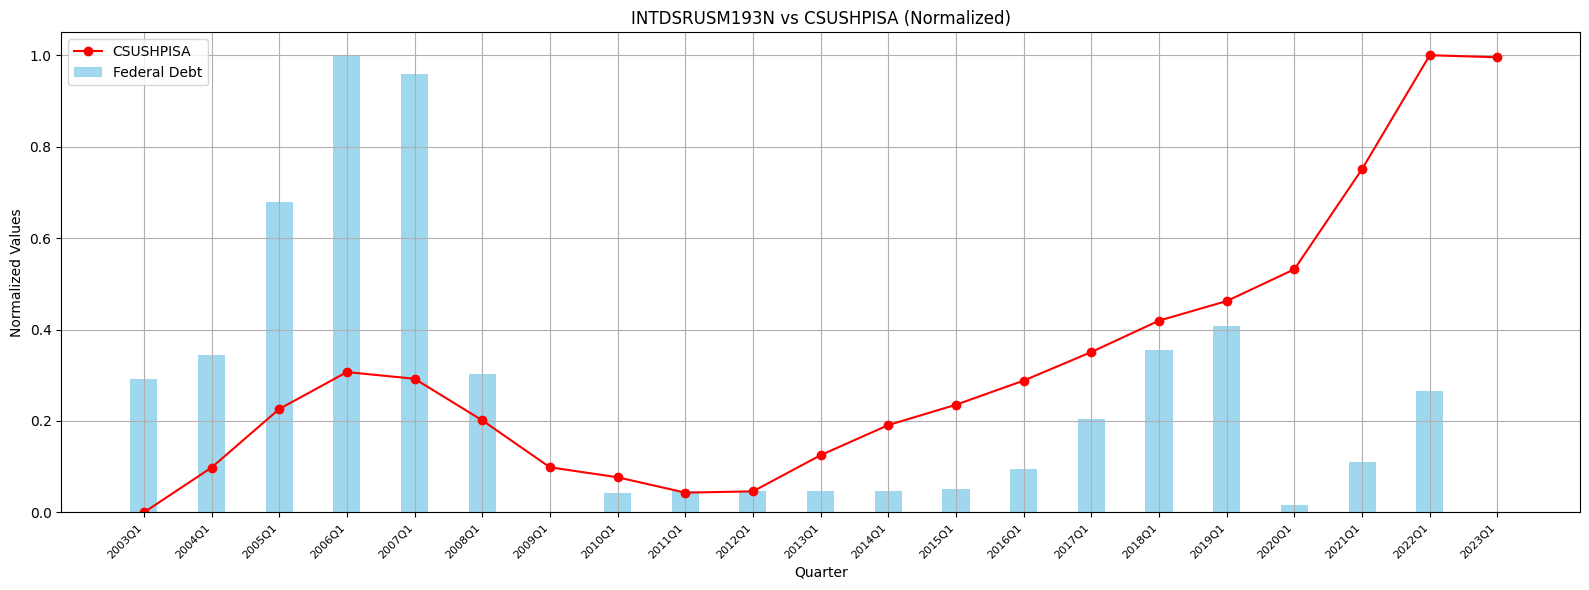

In [130]:
merged_data['QUARTER'] = merged_data.index.to_period('Q')
merged_data['QUARTER'] = merged_data['QUARTER'].astype(str)  # Convert 'QUARTER' values to strings

# Group the data by quarter and calculate the sum of GFDEGDQ188S and the average of CSUSHPISA for each quarter
grouped_data = merged_data.groupby('QUARTER').agg({'INTDSRUSM193N': 'sum', 'CSUSHPISA': 'mean'}).reset_index()

# Normalize the data using min-max scaling
scaler = MinMaxScaler()
grouped_data[['INTDSRUSM193N', 'CSUSHPISA']] = scaler.fit_transform(grouped_data[['INTDSRUSM193N', 'CSUSHPISA']])

# Sort the data by quarter
grouped_data = grouped_data.sort_values('QUARTER')

# Plotting the bar chart
plt.figure(figsize=(16, 6))  # Adjust the figure size as per your preference

bar_width = 0.4
opacity = 0.8

# Bar chart for GFDEGDQ188S
plt.bar(grouped_data['QUARTER'], grouped_data['INTDSRUSM193N'], width=bar_width, alpha=opacity, color='skyblue', label='Federal Debt')

# Line plot for CSUSHPISA
plt.plot(grouped_data['QUARTER'], grouped_data['CSUSHPISA'], marker='o', linestyle='-', color='red', label='CSUSHPISA')

plt.title('INTDSRUSM193N vs CSUSHPISA (Normalized)')
plt.xlabel('Quarter')
plt.ylabel('Normalized Values')
plt.legend()

plt.grid(True)  # Add gridlines
plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotate and align x-axis tick labels for better readability

plt.tight_layout()  # Ensure all elements fit into the figure area
plt.show()

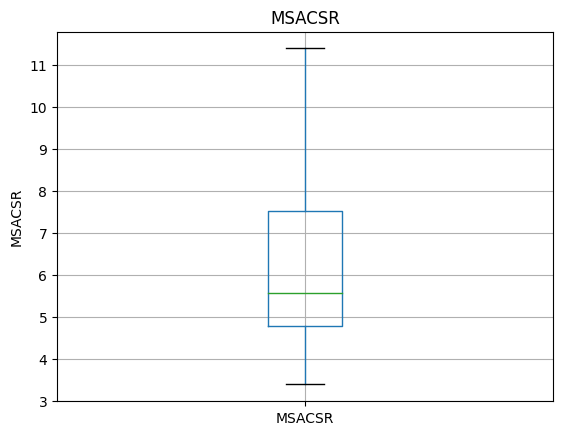

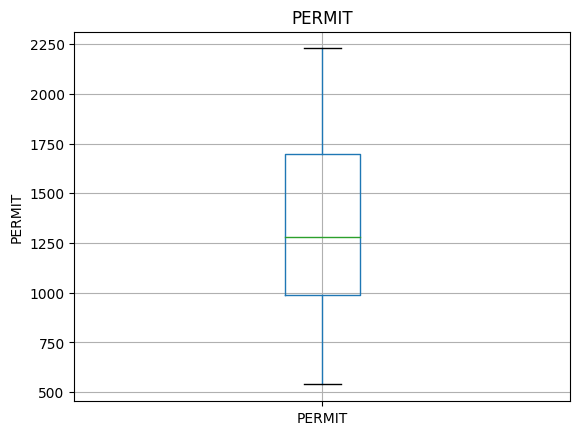

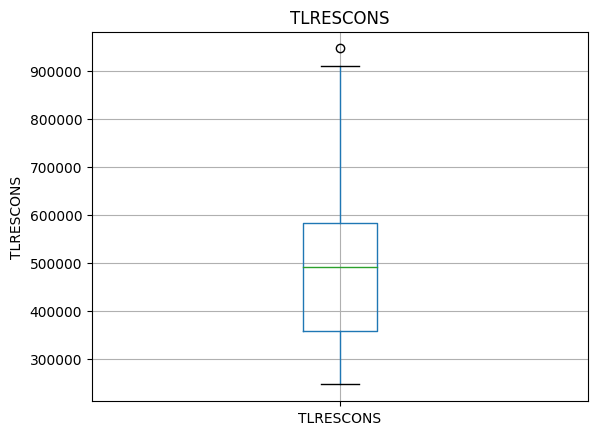

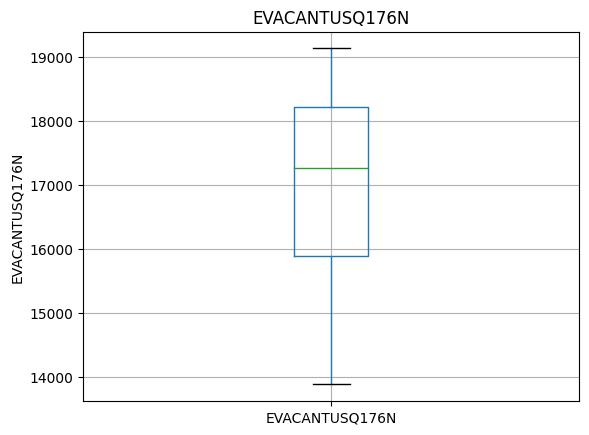

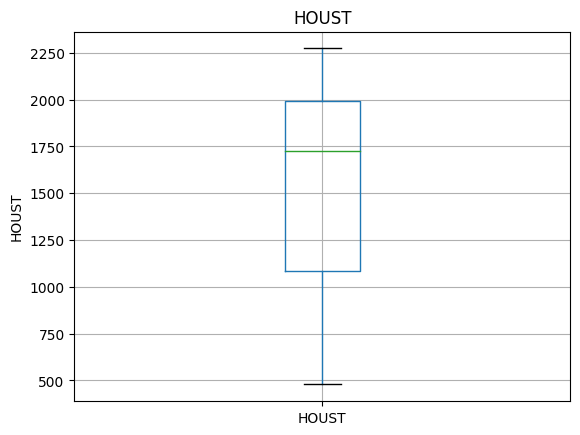

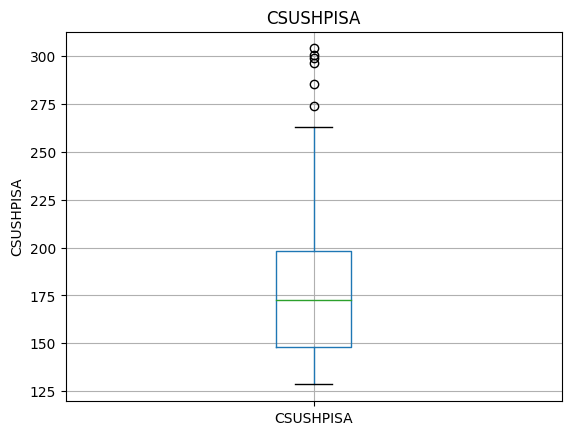

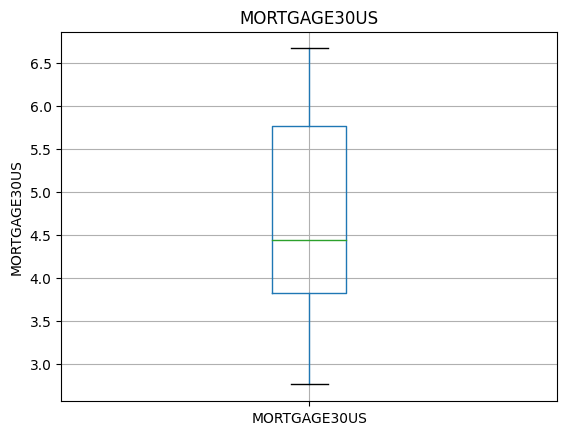

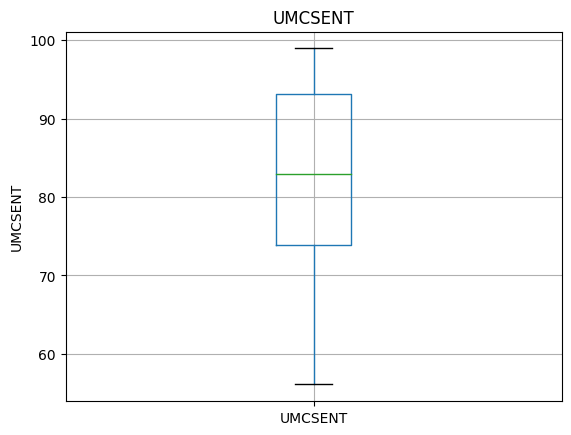

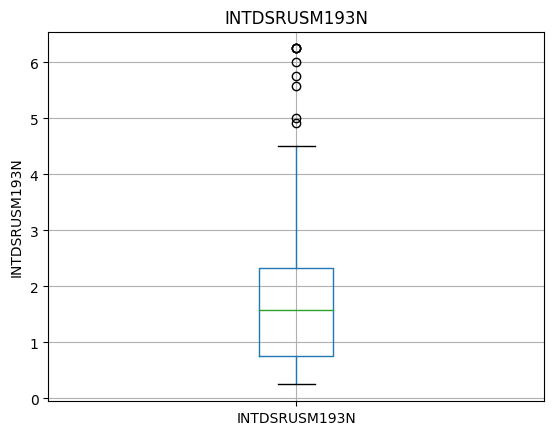

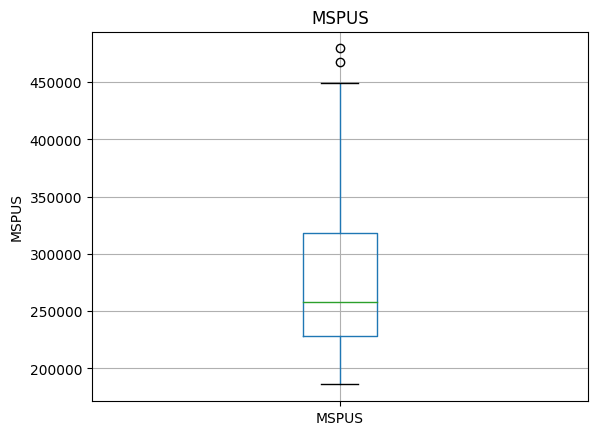

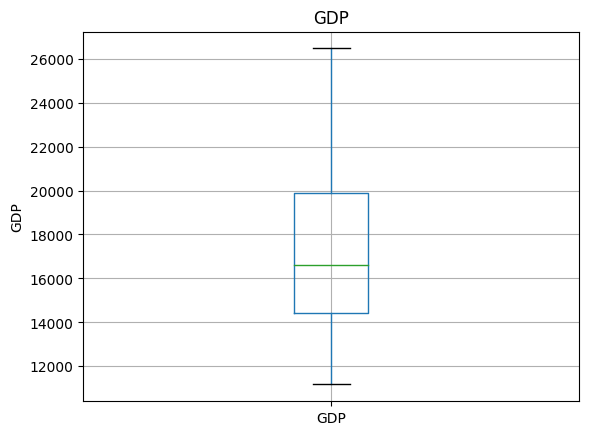

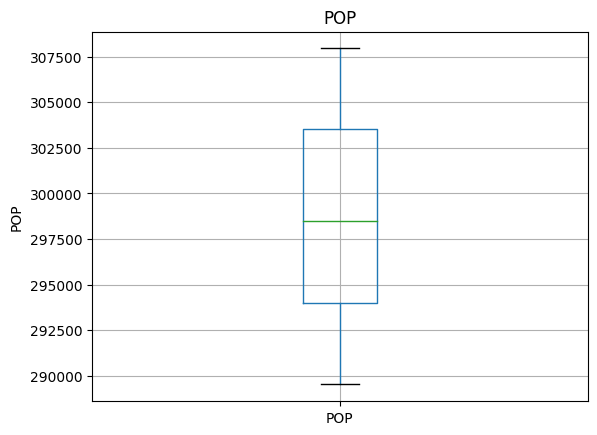

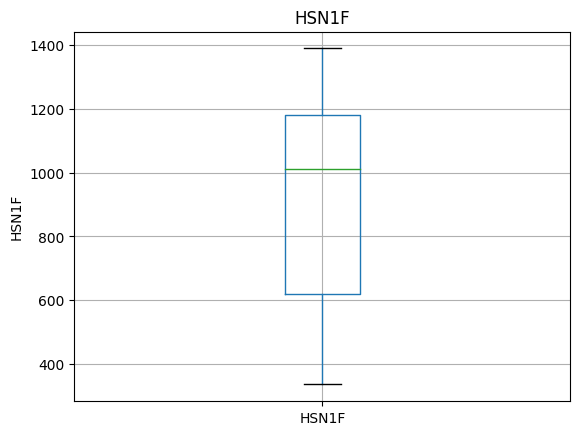

In [119]:
for feature in merged_data.columns:
  data=merged_data.copy()
  if 0 in data[feature].unique():
    pass
  else:
    data.boxplot(column=feature)
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

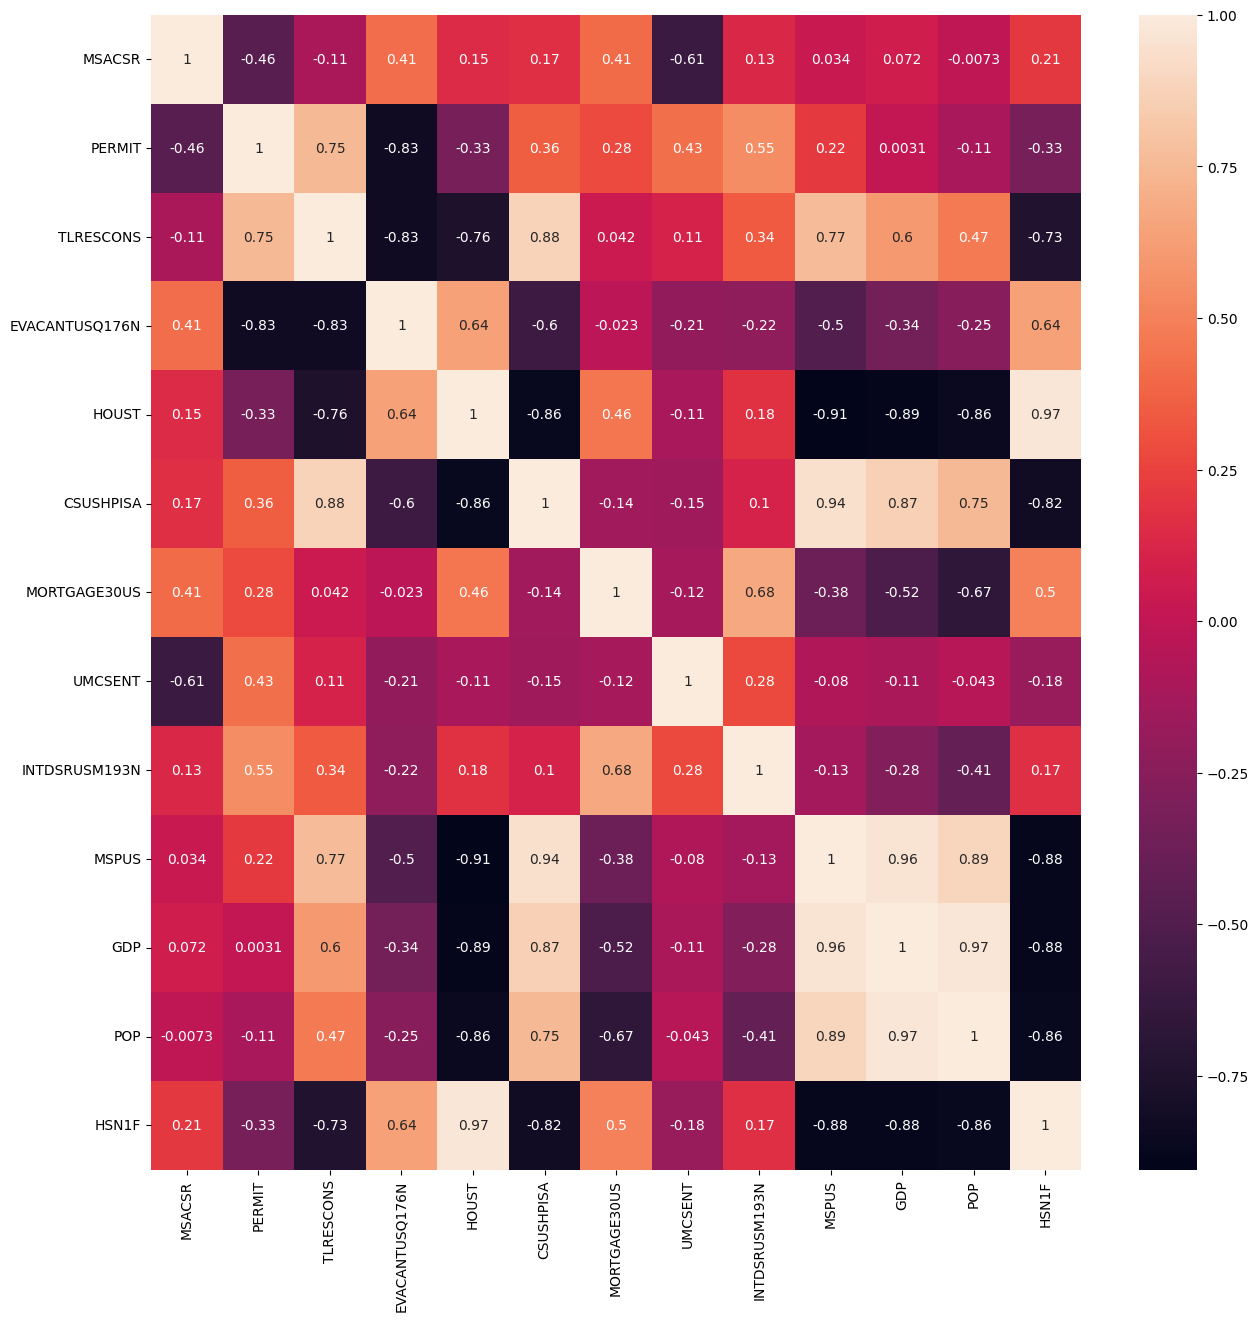

In [120]:
plt.figure(figsize=(15,15))
sns.heatmap(merged_data.corr(),annot=True)
plt.show()

<Figure size 3000x3000 with 0 Axes>

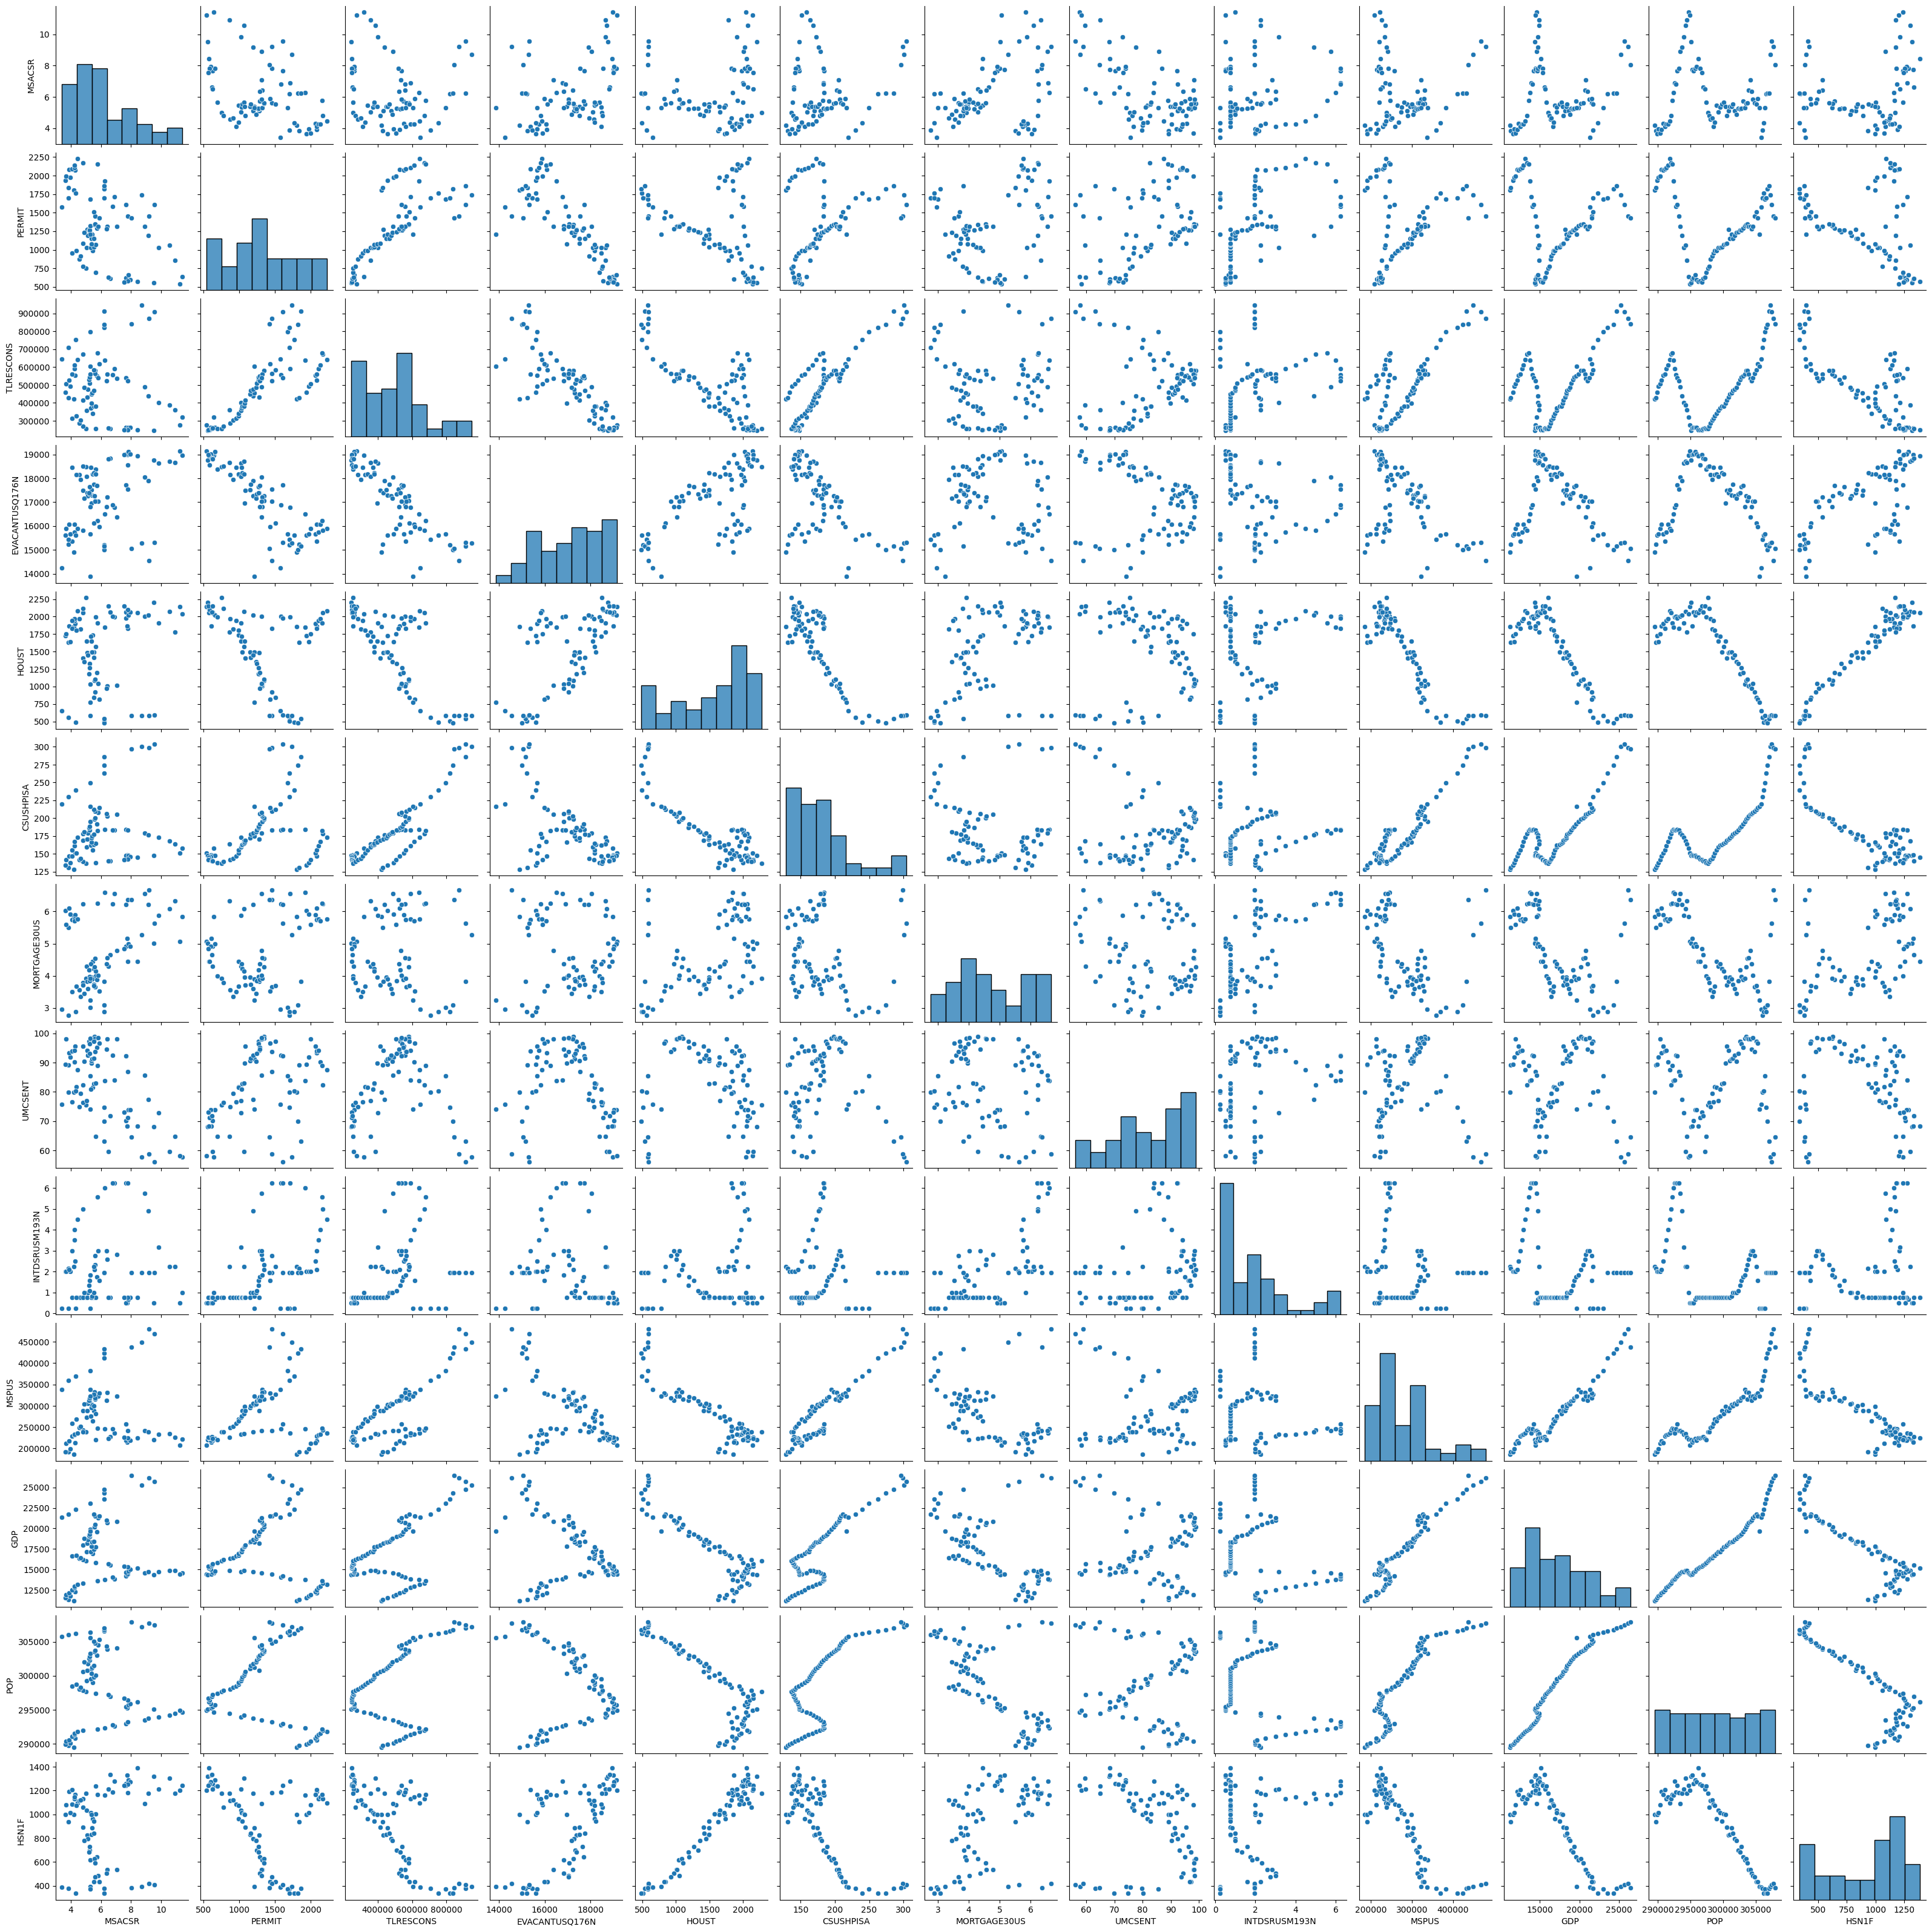

In [121]:
plt.figure(figsize=(30,30))
sns.pairplot(data=merged_data)

## Data Science Model Selection

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

In [122]:
features = ['MSACSR', 'PERMIT', 'TLRESCONS', 'EVACANTUSQ176N', 'HOUST', 'MORTGAGE30US', 'UMCSENT', 'INTDSRUSM193N', 'MSPUS', 'GDP',
       'POP', 'HSN1F']
target = 'CSUSHPISA'

X_train, X_test, y_train, y_test = train_test_split(merged_data[features], merged_data[target], test_size=0.25, random_state=42)

models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Support Vector Regression': SVR(),
    'GBRegressor':GradientBoostingRegressor(),
}

results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -scores
    avg_mse = mse_scores.mean()
    results[model_name] = avg_mse


best_model = min(results, key=results.get)
best_model_instance = models[best_model]


best_model_instance.fit(X_train, y_train)


predictions = best_model_instance.predict(X_test)
mse = mean_squared_error(y_test, predictions)


print("Model Selection Results:")
for model, mse_score in results.items():
    print(f"{model}: MSE={mse_score}")

print(f"\nBest Model: {best_model}")
print(f"Best Model MSE on Testing Set: {mse}")

Model Selection Results:
Linear Regression: MSE=14.577323106011576
Decision Tree: MSE=83.23401593333338
Random Forest: MSE=31.845370601320177
Support Vector Regression: MSE=1795.2132447918916
GBRegressor: MSE=19.29482445855345

Best Model: Linear Regression
Best Model MSE on Testing Set: 17.131178017548525


In [123]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)


print("R-squared score:", r2)

R-squared score: 0.982657777843082


In [124]:
best_model_instance.fit(X_train, y_train)

coefficients = best_model_instance.coef_


print("Coefficients:")
for feature, coefficient in zip(features, coefficients):
    print(f"{feature}: {coefficient}")

Coefficients:
MSACSR: 2.2012790461778464
PERMIT: -0.01770139802451241
TLRESCONS: 0.00014765855793216678
EVACANTUSQ176N: -0.0030193448562900243
HOUST: -0.01698237456260602
MORTGAGE30US: -0.85190896308458
UMCSENT: -0.23821364292378414
INTDSRUSM193N: 2.6898784270159126
MSPUS: -1.776000802401062e-05
GDP: 0.006488987478537269
POP: -0.0010007079467110503
HSN1F: 0.024555496075819246


###**Eveluating the Model**
In our rigorous model evaluation process, we employed two fundamental quantitative metrics—namely, the Mean Squared Error (MSE) and the R-squared score—to gauge the efficacy and robustness of our predictive model. These metrics are pivotal in ascertaining the precision and dependability of our model's predictions, thus facilitating a comprehensive analysis of its performance.

**Mean Squared Error** (MSE):
The Mean Squared Error, or MSE, operates as a pivotal gauge for quantifying the average squared discrepancy between the actual target values and the corresponding predictions generated by our model. A smaller MSE signifies superior model performance, as it signifies reduced prediction errors. Notably, the MSE was meticulously computed on our testing dataset, enabling us to assess the model's ability to generalize its predictions to unseen data.

**R-squared Score** (R^2):
The R-squared score, a quintessential statistical metric, furnishes valuable insights into the extent to which our model expounds the variance inherent in the target variable. This metric assumes values within the range of 0 to 1, with higher values signifying an enhanced model fit. By quantifying the proportion of variance in the target variable that our model elucidates, the R-squared score contributes to a comprehensive comprehension of the explanatory prowess of our independent variables (features) with regard to the dependent variable (target).

Based on our meticulous evaluation, our Linear Regression model exhibited commendable performance across both MSE and R-squared score:

**MSE on Testing Set**: Our model's MSE on the testing dataset registered at a mere 17.13. This relatively low MSE is indicative of the model's ability to generate predictions with minimal errors, underscoring its accuracy.

R-squared Score: The R-squared score yielded a noteworthy value of 0.9826, signifying that approximately 98.26% of the variation within the target variable can be elucidated by our model. This high R-squared score underscores the model's proficiency in explaining the underlying variability in the dependent variable, further substantiating its efficacy.

In addition to these overarching metrics, a detailed analysis of the coefficients generated by our Linear Regression model has been conducted. These coefficients serve as valuable indicators of the significance and impact of each individual feature on the predicted target variable. Notably, certain factors exhibit apparent scaling-related effects, resulting in coefficients that may appear counterintuitive—displaying positive or negative associations. Such nuances have been meticulously considered in our analysis, contributing to a holistic understanding of the model's outcomes and their implications.